In [2]:
from DATAclass import*
from NNclass import*
from MLMETHODS import*

%matplotlib inline

# DATA

### Load

In [3]:
data_raw = DATA('./data/BML.npy' )

In [4]:
data_raw.summary()


 Activities: 
 	    (knock --> 0) (258 samples)
 	    (lift --> 1) (258 samples)
 	    (throw --> 2) (258 samples)
 	    (walk --> 3) (254 samples)

 Number of samples = 1028
 Number of subjects = 30
 Number of features = 8
 Min. data length = 901
 Max. data length = 2401


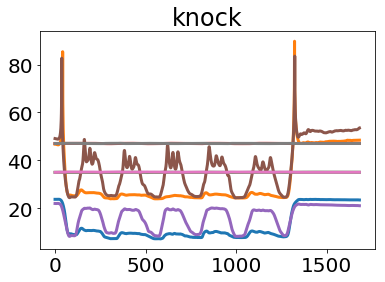

In [5]:
data_raw.show()

### Pre-processing

In [7]:
data = data_raw.clean()                                     # remove NaNs
data = data.filter_noise(window_length=5, polyorder=4)      # filter noise
data = data.standardize(scale=False)                        # zero mean 
data = data.trim(keep_ratio=0.97)                   # trim time

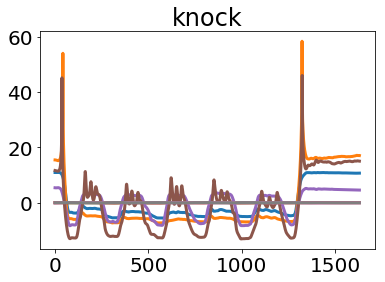

In [8]:
data.show()

### Training and Validation

In [9]:
training_data, validation_data = data.LOSO(validation_subjNum=[3,8])

# Recurrent Neural Network (RNN)

### Build

In [12]:
structural_params = dict( 
    NNtype = 'LSTM', 
    Nlayers = 5, 
    Nunits = 20, 
    TBlength = 60, 
    Nclasses = len(training_data.activity_dict), 
    Nfeatures = np.shape(training_data.X[0])[1],
    optimizerType = 'RMSPropOptimizer',
    decay = 0.95,
    momentum = 0.00,
    learningRate = 0.01,
    expDecaySteps = 100,
    expDecayRate = 0.98
)

rnn = RNN( **structural_params)
rnn.build() 

### Train

In [13]:
training_params = dict(
    Nepochs = 250, 
    stride = 30, 
    batchSize = None, 
    keepProb = 0.8
)

training_results, validation_results = rnn.run( training_data, validation_data, **training_params)

### Results

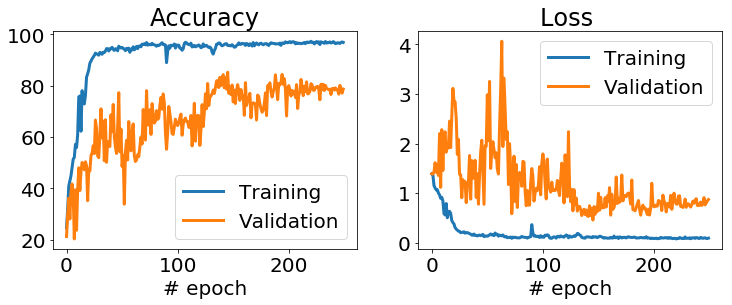

In [14]:
LW = 3 
plt.rcParams.update({'font.size': 20,})
f = plt.figure()      
f.set_figwidth(12)
f.set_figheight(4)

# Accuracy
plt.subplot(121)
plt.plot( np.mean(training_results['accuracy'], axis=1)*100, label='Training', linewidth=LW )
plt.plot( np.mean(validation_results['accuracy'], axis=1)*100, label='Validation', linewidth=LW )
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('# epoch')

# Loss
plt.subplot(122)
plt.plot( np.mean(training_results['loss'], axis=1), label='Training', linewidth=LW )
plt.plot( np.mean(validation_results['loss'], axis=1), label='Validation', linewidth=LW )
plt.legend(loc='upper right')
plt.title('Loss ')
plt.xlabel('# epoch') 
plt.show()

# Machine Learning

### Features


In [11]:
TBlength = 60
stride = 10

training_features = training_data.get_features(TBlength=TBlength, stride=stride)
validation_features = validation_data.get_features(TBlength=TBlength, stride=stride)

### Codewords

In [12]:
Ncodewords = 100

training_codewords = copy.deepcopy(training_features)
validation_codewords = copy.deepcopy(validation_features)

BW = Bag_of_Words( Ncodewords=Ncodewords, training_features=training_features )
training_codewords.X = BW.get_codewords(training_features.X)
validation_codewords.X = BW.get_codewords(validation_features.X)

### Classifiers

##### Support Vector Machine (SVM)

Best Parameters: {'degree': 1, 'kernel': 'poly'}
Accuracy = 79.7 %
Precision = 80.0 %
Recall = 79.7 %
F1 = 0.8


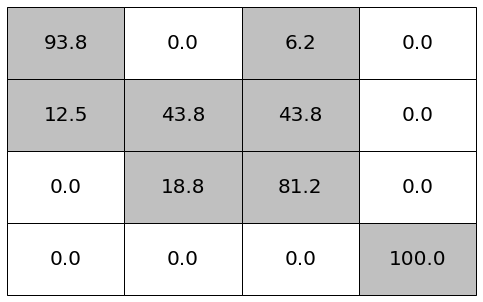

In [71]:
model = svm.SVC()
grid_params = { 
    'kernel' : ['poly', 'rbf'], 
    'degree' : np.arange(1,10) 
}

classifier = CLASSIFIER( model, grid_params )
classifier.train(training_codewords)
classifier.evaluate(validation_codewords)    

##### k-nearest neighbors (KNN)

Best Parameters: {'n_neighbors': 8, 'p': 5}
Accuracy = 75.0 %
Precision = 82.1 %
Recall = 75.0 %
F1 = 0.78


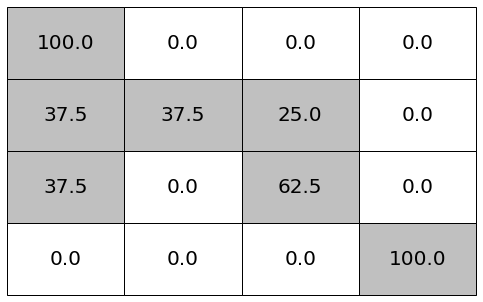

In [73]:
model = neighbors.KNeighborsClassifier()
grid_params = {
    'n_neighbors' : np.arange(1,10), 
    'p' : np.arange(1,10) 
}

classifier = CLASSIFIER( model, grid_params )
classifier.train(training_codewords)
classifier.evaluate(validation_codewords)    

##### Decision Tree (DT)

Best Parameters: {'criterion': 'gini'}
Accuracy = 76.6 %
Precision = 75.8 %
Recall = 76.6 %
F1 = 0.76


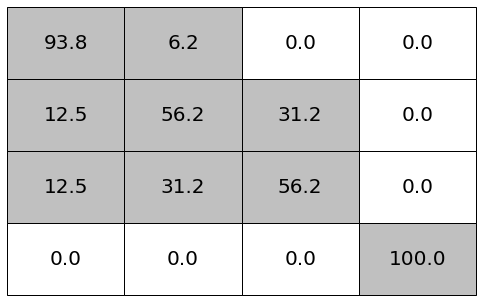

In [74]:
model = tree.DecisionTreeClassifier()
grid_params = { 
    'criterion' : ['gini', 'entropy'] 
}

classifier = CLASSIFIER( model, grid_params )
classifier.train(training_codewords)
classifier.evaluate(validation_codewords)

##### Random Forest (RF)

Best Parameters: {'criterion': 'entropy', 'n_estimators': 25}
Accuracy = 81.2 %
Precision = 83.1 %
Recall = 81.2 %
F1 = 0.82


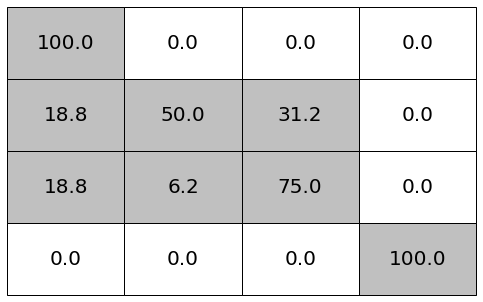

In [80]:
model = ensemble.RandomForestClassifier()
grid_params = {
    'criterion' : ['gini', 'entropy'], 
    'n_estimators' : np.arange(1,30) 
}

classifier = CLASSIFIER( model, grid_params )
classifier.train(training_codewords)
classifier.evaluate(validation_codewords)

##### Logistic Regression (LR)

Best Parameters: {'penalty': 'l1'}
Accuracy = 78.1 %
Precision = 78.3 %
Recall = 78.1 %
F1 = 0.78


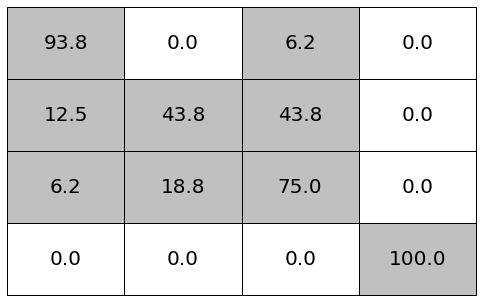

In [81]:
model = linear_model.LogisticRegression()
grid_params = {
    'penalty' : ['l1', 'l2']
}

classifier = CLASSIFIER( model, grid_params )
classifier.train(training_codewords)
classifier.evaluate(validation_codewords)